In [6]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from ase import data
from ase.visualize import view
from ase.io.trajectory import Trajectory

from asap3.analysis.rdf import RadialDistributionFunction

from frozendict import frozendict

from tqdm import tqdm

from vibrational_amplitudes import *

# Radial Distribution Function Analysis

In [7]:
MD_traj = Trajectory('trajectory_data/md-hot.traj','r')
n_steps = len(MD_traj)

# I will take the last half of the MD simulation in order to only include the thermal vibrations 
# after thermalisation
thermalised_traj = MD_traj[-int(n_steps*0.5):]

# Final trajectory
final_atoms = thermalised_traj[-1]
n_atoms = len(final_atoms)

# Trajectory with averaged positions
# Obtain all poistions of each atom throughout the MD steps
allpos = np.empty(( int(n_steps*0.5), n_atoms, 3))
for i, atoms in enumerate(thermalised_traj):
    pos = atoms.get_positions()
    allpos[i] = pos

avg_pos = np.mean(allpos,axis=0)
avg_atoms = final_atoms.copy()
avg_atoms.set_positions(avg_pos)

MD_traj.close()

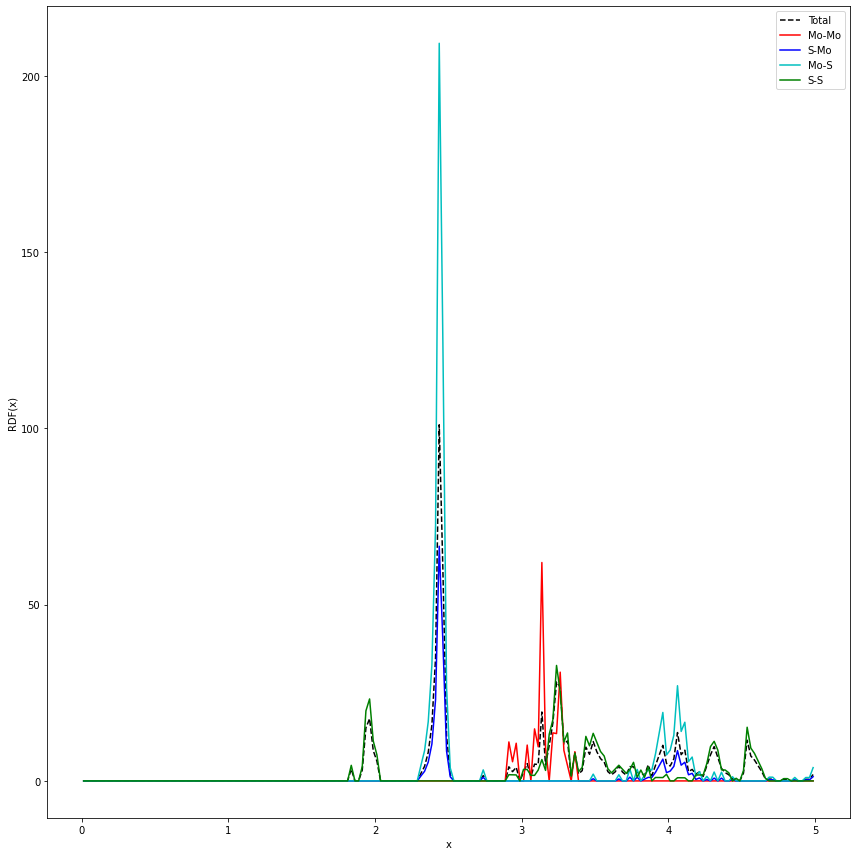

In [8]:
rMax=5    # Max radius in Ångstrøm
nBins=200 # Number of bins 
RDFobj = RadialDistributionFunction(avg_atoms, rMax=rMax, nBins=nBins)

rdf = RDFobj.get_rdf()
x = (np.arange(nBins) + 0.5) * rMax / nBins

plt.figure(figsize=(12,12))
plt.plot(x,rdf, 'k--')

# Get the partial RDFs and plot them
Mo = data.atomic_numbers['Mo']
S = data.atomic_numbers['S']

rdfMoMo = RDFobj.get_rdf(elements=(Mo, Mo))
plt.plot(x,rdfMoMo, 'r')

rdfSMo = RDFobj.get_rdf(elements=(S, Mo))
plt.plot(x,rdfSMo, 'b')

rdfMoS = RDFobj.get_rdf(elements=(Mo, S))
plt.plot(x,rdfMoS, 'c')

rdfSS = RDFobj.get_rdf(elements=(S, S))
plt.plot(x,rdfSS, 'g')

plt.legend(['Total', 'Mo-Mo', 'S-Mo','Mo-S','S-S'])
plt.ylabel('RDF(x)')
plt.xlabel('x')

plt.tight_layout()
plt.show()

# Extract Amplitudes

In [22]:
MD_traj1 = Trajectory('trajectory_data/md-hot.traj','r')
#MD_traj2 = Trajectory('trajectory_data/md_defect.traj','r')
#MD_traj3 = Trajectory('trajectory_data/md_defect-2.traj','r')
#MD_traj4 = Trajectory('trajectory_data/md_defect-3.traj','r')
#MD_traj5 = Trajectory('trajectory_data/md_large_defect.traj','r')
#MD_traj6 = Trajectory('trajectory_data/md_large_defect-2.traj','r')

thermalised_traj1 = MD_traj1[-int(len(MD_traj1)*0.5):]
#thermalised_traj2 = MD_traj2[-int(len(MD_traj2)*0.5):]
#thermalised_traj3 = MD_traj3[-int(len(MD_traj3)*0.5):]
#thermalised_traj4 = MD_traj4[-int(len(MD_traj4)*0.5):]
#thermalised_traj5 = MD_traj5[-int(len(MD_traj5)*0.5):]
#thermalised_traj6 = MD_traj6[-int(len(MD_traj6)*0.5):]

trajectories = [thermalised_traj1]
#trajectories = [ thermalised_traj1, thermalised_traj2, thermalised_traj3, 
#                thermalised_traj4, thermalised_traj5, thermalised_traj6 ]

# Vibrational amplitudes of S for Mo nearest neighbours
VA_MoMo, er_MoMo = get_vibrational_amplitudes(trajectories, element=42, nb_element=42, rcut=3.5)
VA_MoS, er_MoS = get_vibrational_amplitudes(trajectories, element=42, nb_element=16, rcut=2.8)
VA_SMo, er_SMo = get_vibrational_amplitudes(trajectories, element=16, nb_element=42, rcut=2.8)
VA_SS, er_SS = get_vibrational_amplitudes(trajectories, element=16, nb_element=16, rcut=3.5)
VA_MoT, er_MoT = get_vibrational_amplitudes(trajectories, element=42, nb_element=None, rcut=3.5)
VA_ST, er_ST = get_vibrational_amplitudes(trajectories, element=16, nb_element=None, rcut=3.5)

MD_traj1.close()
#MD_traj2.close()
#MD_traj3.close()
#MD_traj4.close()
#MD_traj5.close()
#MD_traj6.close()

VAs = [ VA_MoMo, VA_MoS, VA_SMo, VA_SS, VA_MoT, VA_ST ]
ers = [ er_MoMo, er_MoS, er_SMo, er_SS, er_MoT, er_ST ]
VA_tags = ['Mo->Mo', 'Mo->S', 'S->Mo', 'S->S', 'Mo->All', 'S->All']

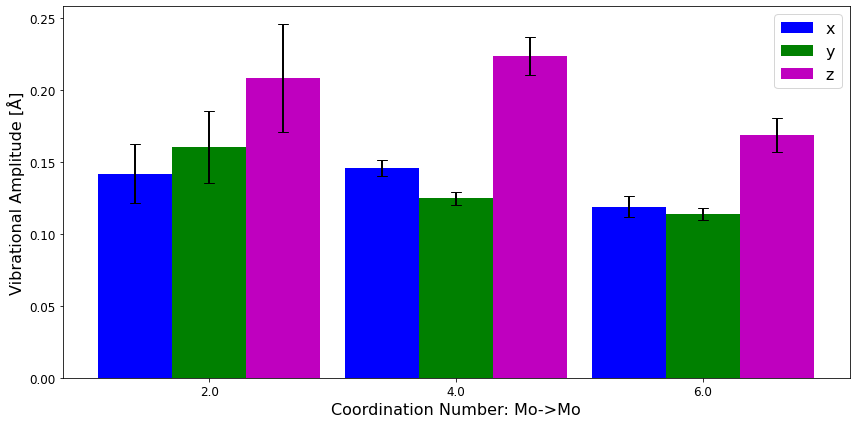

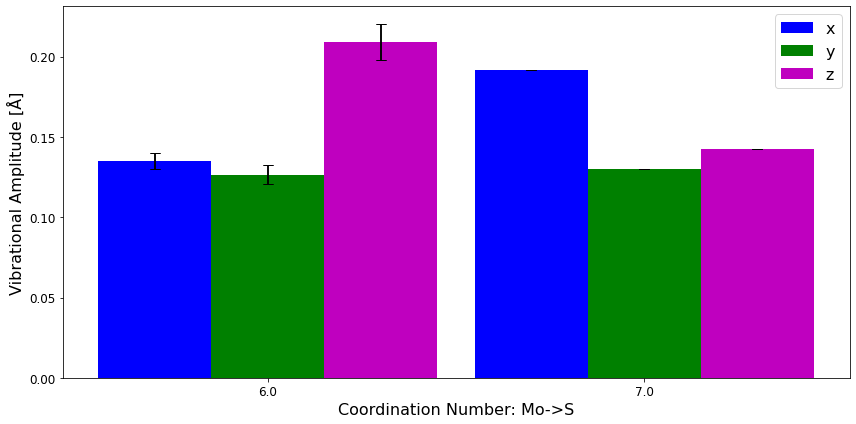

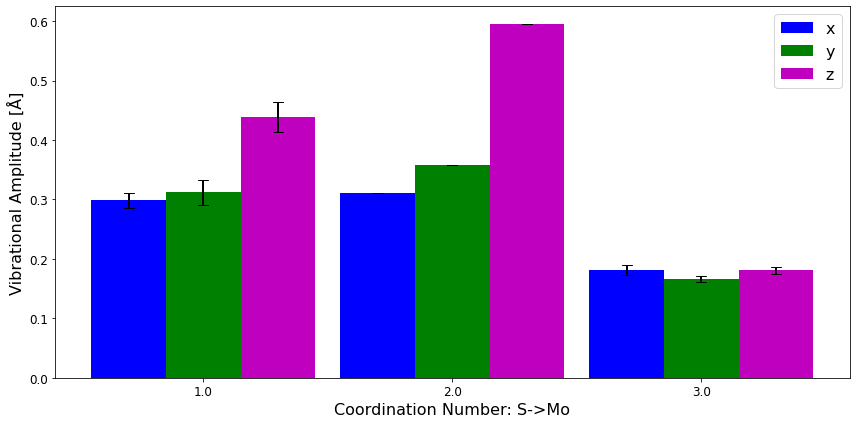

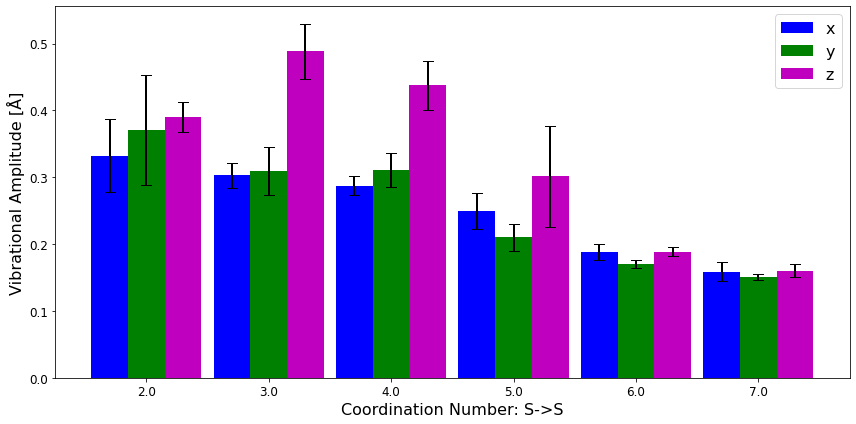

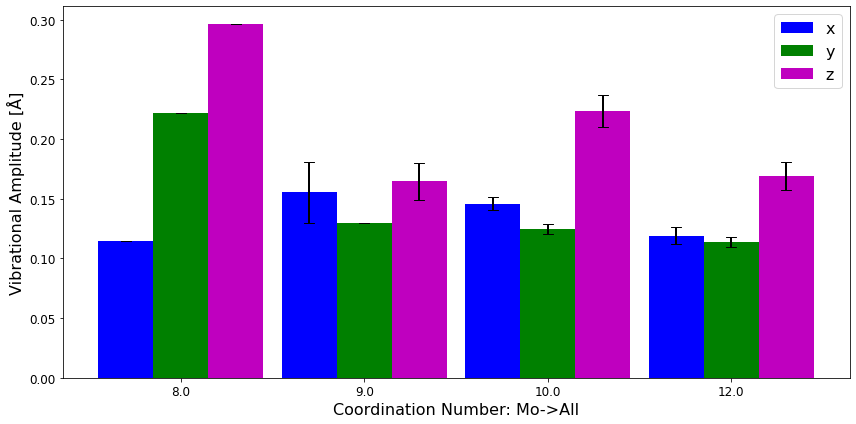

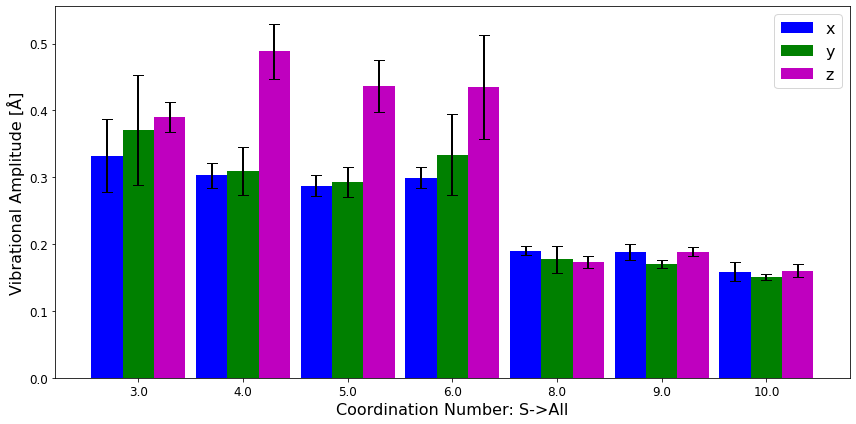

In [23]:
for i, VA in enumerate(VAs):
    w = [0.3,]*len(VA)
    er = ers[i]
    fig = plt.figure(figsize=(12,6))
    for x, y in enumerate(VA.values()):
        err = er[list(VA.keys())[x]]
        x = np.array([x,]*len(VA))
        plt.bar(x-w, y[0], yerr=err[0], width=w, color='b', align='center', ecolor='black', capsize=5)
        plt.bar(x, y[1], yerr=err[1], width=w, color='g', align='center', ecolor='black', capsize=5)
        plt.bar(x+w, y[2], yerr=err[2], width=w, color='m', align='center', ecolor='black', capsize=5)
    plt.xticks(range(len(VA)), list(VA.keys()),fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlabel('Coordination Number: {}'.format(VA_tags[i]),fontsize=16)
    plt.ylabel('Vibrational Amplitude [Å]',fontsize=16)
    plt.legend(['x','y','z'],fontsize=16)
    #plt.title(VA_tags[i])
    
    plt.tight_layout()
    plt.show()

# Perturb Atoms

In [7]:
trajectory = Trajectory('trajectory_data/relax.traj','r')
atoms = trajectory[0].copy()
trajectory.close()

patoms = perturb_atoms(atoms=atoms, rcut=3.5, ele_A=42, va_A=VA_MoT, ele_B=16, va_B=VA_ST)

In [8]:
atoms.write('trajectory_data/fp-hot.traj')          # write initial configuraiton
t1 = Trajectory('trajectory_data/fp-hot.traj', 'a') # open in append mode
for i in tqdm(np.arange(1,2500)):
    patoms = perturb_atoms(atoms=atoms, rcut=3.5, ele_A=42, va_A=VA_MoT, ele_B=16, va_B=VA_ST)
    t1.write(patoms)
t1.close()

100%|██████████| 2499/2499 [00:09<00:00, 277.12it/s]
